# Assignment 8: Spatial data and Magic: The Gathering

Author: Danny Nielsen

**NB**: Throughout this notebook, I will put a limit on every large query result, so that this document won't be a pain to scroll through on a reader (like Github).

### Notebook setup

In [1]:
%load_ext sql

In [131]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
%sql postgresql://appdev@data:5432/appdev

'Connected: appdev@appdev'

## 1) Geonames processing

### A) Find the tuple with the largest population

In [146]:
%%sql CREATE OR REPLACE VIEW largest_population AS 
SELECT name, longitude, latitude, MAX(population) AS population 
FROM geonames 
GROUP BY name, longitude, latitude 
ORDER BY population DESC 
LIMIT 1;

Done.


[]

In [27]:
%sql SELECT * FROM largest_population;

1 rows affected.


name,longitude,latitude,population
Levant,36.0,34.0,44990000


### B) Now calculate the distance from all locations to the tuple above using the <-> function

In [47]:
%%sql SELECT geonames.name, point(geonames.longitude, geonames.latitude) <-> point(largest_population.longitude, largest_population.latitude) 
AS distance_from_tuple 
FROM geonames, largest_population 
ORDER BY distance_from_tuple DESC
LIMIT 10;

10 rows affected.


name,distance_from_tuple
Eckins Nunatak,243.041567580299
Nairn River,226.392811281631
Waikato,226.321369487677
Cox Peaks,224.32621893127
Tuvumatha,221.784518170228
Savusavu,221.778802715178
Vaua Creek,221.732030326899
"Howe, Mount",221.675705901411
Muaidakewa Point,221.554254857319
Breckinridge Peak,221.550265350276


### C) Now calculate the distance from all locations to the tuple above using the haversine distance

Implementing the function.

In [43]:
%%sql CREATE OR REPLACE FUNCTION public.geodistance(alat double precision, alng double precision, blat double precision, blng double precision)
  RETURNS double precision AS
$BODY$
SELECT asin(
  sqrt(
    sin(radians($3-$1)/2)^2 +
    sin(radians($4-$2)/2)^2 *
    cos(radians($1)) *
    cos(radians($3))
  )
) * 7926.3352 AS distance;
$BODY$
  LANGUAGE sql IMMUTABLE
  COST 100;

Done.


[]

In [50]:
%%sql SELECT geonames.name, geodistance(geonames.latitude, geonames.longitude, largest_population.latitude, largest_population.longitude)
AS distance_from_tuple 
FROM geonames, largest_population 
ORDER BY distance_from_tuple DESC
LIMIT 10;

10 rows affected.


name,distance_from_tuple
Vaiuru,11715.8987043352
Récif Tanai,11713.6888161383
Rivière Arepua,11670.2402692639
Teupukahaia,11442.0459098265
Hikueru,11309.5337147678
Mont Rauiri,11287.0849649269
Passe de Vaionifa,11284.0217418805
Taharoa,11280.1006183287
Passe de Maraa,11273.945244135
Toetoe,11271.7284378992


### D) Plot the latitude and longitude of the largest 1000 populations on a 2-D scatter plot

In [97]:
latitude = %sql SELECT latitude, MAX(population) FROM geonames GROUP BY latitude ORDER BY MAX(population) LIMIT 1000;

1000 rows affected.


In [98]:
longitude = %sql SELECT longitude, MAX(population) FROM geonames GROUP BY longitude ORDER BY MAX(population) LIMIT 1000;

1000 rows affected.


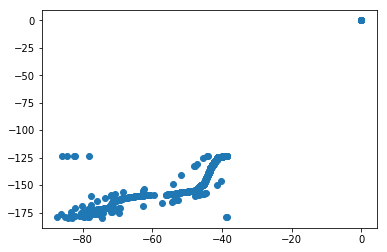

In [108]:
plt.scatter(latitude, longitude)

## 2) "Magic: The Gathering" JSON processing

### A) Find all the cards that is made by Rob Alexander

In [148]:
%sql SELECT jsonb_pretty(data) FROM cards WHERE data @> '{"artist":"Rob Alexander"}' LIMIT 10;

10 rows affected.


jsonb_pretty
"{ ""id"": ""4a7bf234af44e07d9a159d4d89e96ce320919917"", ""cmc"": 6, ""name"": ""Beacon of Immortality"", ""text"": ""Double target player's life total. Shuffle Beacon of Immortality into its owner's library."", ""type"": ""Instant"", ""types"": [ ""Instant"" ], ""artist"": ""Rob Alexander"", ""colors"": [ ""White"" ], ""flavor"": ""The cave floods with light. A thousand rays shine forth and meld into one."", ""layout"": ""normal"", ""number"": ""10"", ""rarity"": ""Rare"", ""manaCost"": ""{5}{W}"", ""imageName"": ""beacon of immortality"", ""mciNumber"": ""10"", ""multiverseid"": 130553, ""colorIdentity"": [ ""W"" ]}"
"{ ""id"": ""9cea331c080c3bbc7987c6560f65e39e9d1ed34f"", ""cmc"": 5, ""name"": ""Kavu Climber"", ""text"": ""When Kavu Climber enters the battlefield, draw a card."", ""type"": ""Creature — Kavu"", ""power"": ""3"", ""types"": [ ""Creature"" ], ""artist"": ""Rob Alexander"", ""colors"": [ ""Green"" ], ""flavor"": ""\""There was a crack of branches, a rustle of leaves, then a tremendous roar. Our party had no chance as death descended from above.\""\n—Taseen, elvish bard"", ""layout"": ""normal"", ""number"": ""273"", ""rarity"": ""Common"", ""manaCost"": ""{3}{G}{G}"", ""subtypes"": [ ""Kavu"" ], ""imageName"": ""kavu climber"", ""mciNumber"": ""273"", ""toughness"": ""3"", ""multiverseid"": 129511, ""colorIdentity"": [ ""G"" ]}"
"{ ""id"": ""28cc7c79cca8939fd9661f7abfc6ca453715b75e"", ""cmc"": 0, ""name"": ""Llanowar Wastes"", ""text"": ""{T}: Add {C} to your mana pool.\n{T}: Add {B} or {G} to your mana pool. Llanowar Wastes deals 1 damage to you."", ""type"": ""Land"", ""types"": [ ""Land"" ], ""artist"": ""Rob Alexander"", ""layout"": ""normal"", ""number"": ""355"", ""rarity"": ""Rare"", ""imageName"": ""llanowar wastes"", ""mciNumber"": ""355"", ""multiverseid"": 129627, ""colorIdentity"": [ ""B"", ""G"" ]}"
"{ ""id"": ""7a90b7ba6197f8774ed99ecf75ac9abb3e0c0f20"", ""cmc"": 0, ""name"": ""Shivan Reef"", ""text"": ""{T}: Add {C} to your mana pool.\n{T}: Add {U} or {R} to your mana pool. Shivan Reef deals 1 damage to you."", ""type"": ""Land"", ""types"": [ ""Land"" ], ""artist"": ""Rob Alexander"", ""layout"": ""normal"", ""number"": ""357"", ""rarity"": ""Rare"", ""imageName"": ""shivan reef"", ""mciNumber"": ""357"", ""multiverseid"": 129731, ""colorIdentity"": [ ""U"", ""R"" ]}"
"{ ""id"": ""8d1035f151615c949d0645b70fe01d8ab4a3f796"", ""cmc"": 0, ""name"": ""Sulfurous Springs"", ""text"": ""{T}: Add {C} to your mana pool.\n{T}: Add {B} or {R} to your mana pool. Sulfurous Springs deals 1 damage to you."", ""type"": ""Land"", ""types"": [ ""Land"" ], ""artist"": ""Rob Alexander"", ""layout"": ""normal"", ""number"": ""359"", ""rarity"": ""Rare"", ""imageName"": ""sulfurous springs"", ""mciNumber"": ""359"", ""multiverseid"": 129751, ""colorIdentity"": [ ""B"", ""R"" ]}"
"{ ""id"": ""c97103ab834aad9b3fb7d07c4fb563089f97fe87"", ""cmc"": 0, ""name"": ""Treetop Village"", ""text"": ""Treetop Village enters the battlefield tapped.\n{T}: Add {G} to your mana pool.\n{1}{G}: Treetop Village becomes a 3/3 green Ape creature with trample until end of turn. It's still a land. (If it would assign enough damage to its blockers to destroy them, you may have it assign the rest of its damage to defending player or planeswalker.)"", ""type"": ""Land"", ""types"": [ ""Land"" ], ""artist"": ""Rob Alexander"", ""layout"": ""normal"", ""number"": ""361"", ""rarity"": ""Uncommon"", ""imageName"": ""treetop village"", ""mciNumber"": ""361"", ""multiverseid"": 106455, ""colorIdentity"": [ ""G"" ]}"
"{ ""id"": ""24a47bf9cb4596246501294e7127bf74e082bc1d"", ""cmc"": 0, ""name"": ""Plains"", ""type"": ""Basic Land — Plains"", ""types"": [ ""Land"" ], ""artist"": ""Rob Alexander"", ""layout"": ""normal"", ""number"": ""364"", ""rarity"": ""Basic Land"", ""subtypes"": [ ""Plains"" ], ""imageName"": ""plains1"", ""watermark"": ""White"", ""supertypes"": [ ""Basic"" ], ""variations"": [ 129682, 129683, 129681 ], ""multiverseid

### B) Find all the cards that have the subtype "Human"

In [147]:
%sql SELECT jsonb_pretty(data) FROM cards WHERE data @> '{"subtypes":["Human"]}'  LIMIT 10;

10 rows affected.


jsonb_pretty
"{ ""id"": ""ab1ab474019e4e76c66e2b524d354cb7c3212616"", ""cmc"": 7, ""name"": ""Ancestor's Chosen"", ""text"": ""First strike (This creature deals combat damage before creatures without first strike.)\nWhen Ancestor's Chosen enters the battlefield, you gain 1 life for each card in your graveyard."", ""type"": ""Creature — Human Cleric"", ""power"": ""4"", ""types"": [ ""Creature"" ], ""artist"": ""Pete Venters"", ""colors"": [ ""White"" ], ""flavor"": ""\""The will of all, by my hand done.\"""", ""layout"": ""normal"", ""number"": ""1"", ""rarity"": ""Uncommon"", ""manaCost"": ""{5}{W}{W}"", ""subtypes"": [ ""Human"", ""Cleric"" ], ""imageName"": ""ancestor's chosen"", ""mciNumber"": ""1"", ""toughness"": ""4"", ""multiverseid"": 130550, ""colorIdentity"": [ ""W"" ]}"
"{ ""id"": ""d3488c0a916bd922856473155a8b49ec23fc2217"", ""cmc"": 4, ""name"": ""Ballista Squad"", ""text"": ""{X}{W}, {T}: Ballista Squad deals X damage to target attacking or blocking creature."", ""type"": ""Creature — Human Rebel"", ""power"": ""2"", ""types"": [ ""Creature"" ], ""artist"": ""Matthew D. Wilson"", ""colors"": [ ""White"" ], ""flavor"": ""The perfect antidote for a tightly packed formation."", ""layout"": ""normal"", ""number"": ""8"", ""rarity"": ""Uncommon"", ""manaCost"": ""{3}{W}"", ""subtypes"": [ ""Human"", ""Rebel"" ], ""imageName"": ""ballista squad"", ""mciNumber"": ""8"", ""toughness"": ""2"", ""multiverseid"": 129477, ""colorIdentity"": [ ""W"" ]}"
"{ ""id"": ""29c46fca29e5de01dba3bbf05393325bc9132735"", ""cmc"": 3, ""name"": ""Benalish Knight"", ""text"": ""Flash (You may cast this spell any time you could cast an instant.)\nFirst strike (This creature deals combat damage before creatures without first strike.)"", ""type"": ""Creature — Human Knight"", ""power"": ""2"", ""types"": [ ""Creature"" ], ""artist"": ""Zoltan Boros & Gabor Szikszai"", ""colors"": [ ""White"" ], ""flavor"": ""\""We called them 'armored lightning.'\""\n—Gerrard of the Weatherlight"", ""layout"": ""normal"", ""number"": ""11"", ""rarity"": ""Common"", ""manaCost"": ""{2}{W}"", ""subtypes"": [ ""Human"", ""Knight"" ], ""imageName"": ""benalish knight"", ""mciNumber"": ""11"", ""toughness"": ""2"", ""multiverseid"": 136279, ""colorIdentity"": [ ""W"" ]}"
"{ ""id"": ""e8b8dea65daf4e9070cce5de62bdbea0bf36d47c"", ""cmc"": 4, ""name"": ""Cho-Manno, Revolutionary"", ""text"": ""Prevent all damage that would be dealt to Cho-Manno, Revolutionary."", ""type"": ""Legendary Creature — Human Rebel"", ""power"": ""2"", ""types"": [ ""Creature"" ], ""artist"": ""Steven Belledin"", ""colors"": [ ""White"" ], ""flavor"": ""\""Mercadia's masks can no longer hide the truth. Our day has come at last.\"""", ""layout"": ""normal"", ""number"": ""12"", ""rarity"": ""Rare"", ""manaCost"": ""{2}{W}{W}"", ""subtypes"": [ ""Human"", ""Rebel"" ], ""imageName"": ""cho-manno, revolutionary"", ""mciNumber"": ""12"", ""toughness"": ""2"", ""supertypes"": [ ""Legendary"" ], ""multiverseid"": 130554, ""colorIdentity"": [ ""W"" ]}"
"{ ""id"": ""80a6b907fc380ed97615e8abc0fe6071c4ceef67"", ""cmc"": 3, ""name"": ""Field Marshal"", ""text"": ""Other Soldier creatures get +1/+1 and have first strike. (They deal combat damage before creatures without first strike.)"", ""type"": ""Creature — Human Soldier"", ""power"": ""2"", ""types"": [ ""Creature"" ], ""artist"": ""Stephen Tappin"", ""colors"": [ ""White"" ], ""flavor"": ""He is the only one who sees the patterns in the overlapping maps and conflicting reports."", ""layout"": ""normal"", ""number"": ""15"", ""rarity"": ""Rare"", ""manaCost"": ""{1}{W}{W}"", ""subtypes"": [ ""Human"", ""Soldier"" ], ""imageName"": ""field marshal"", ""mciNumber"": ""15"", ""toughness"": ""2"", ""multiverseid"": 135258, ""colorIdentity"": [ ""W"" ]}"
"{ ""id"": ""7879b835a2c3d6516515d03bd3a3894dceee1812"", ""cmc"": 1, ""name"": ""Honor Guard"", ""text"": ""{W}: Honor Guard gets +0/+1 until end of turn."", ""type"": ""Creature — Human Soldier"", ""power

### C) Group all the cards based on the colour. Aggregate them by counting the number of cards per colour.

In [5]:
cardsByColor = %sql SELECT jsonb_pretty(data -> 'colors') as colors, count(*) FROM cards GROUP BY colors ORDER BY count(*) DESC;

32 rows affected.


In [28]:
cardsByColor

colors,count
None,7391
"[ ""Green""]",4977
"[ ""Black""]",4877
"[ ""Red""]",4858
"[ ""White""]",4755
"[ ""Blue""]",4680
"[ ""White"", ""Green""]",276
"[ ""Red"", ""Green""]",273
"[ ""Blue"", ""Black""]",260
"[ ""Black"", ""Red""]",258


<Container object of 32 artists>

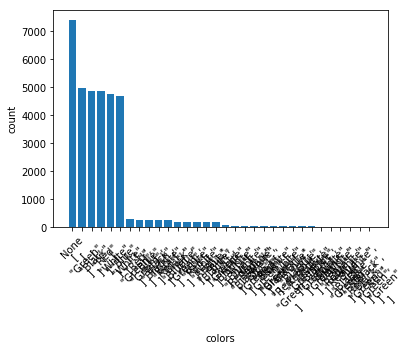

In [145]:
cardsByColor.bar()

Very hideous representation, but unfortunately I didn't have any luck with `matplotlib.pyplot.hist`. 